# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 3 weeks for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hands. 

### Task 1 <a id="task1"></a> (0.5 points)

Implement the function `H()` which calculates impurity criterion. We will be training regression tree, therefore, impurity criterion will be variance.

* You cannot use loops
* If `y` is empty, the function should return 0

In [2]:
def H(y):
    """
    Calculate impurity criterion
    
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if len(y) == 0:
        return 0
    return np.sum((y - np.mean(y)) ** 2) / len(y)

In [3]:
# Test the function
assert np.allclose(H(np.array([4,2,2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [4]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """   

    x_col = X[:, j]
    mask = x_col < t

    rl = y[mask]
    rr = y[~mask]
    
    Q = len(rl) / len(y) * H(rl) + len(rr) / len(y) * H(rr)
    
    return Q

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [5]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    left : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node (average values calculated on a train dataset)
        
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'.format(self.column, self.threshold, self.prediction)
        return node_desc

In [6]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """ 
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
            
    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node. 
        Try all features and thresholds. 
        
        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels. 
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child. 
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child. 
        """
        
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        # without splitting
        best_cost = H(y) 
        
        for j in range(X.shape[1]): # n_features
            x_col = X[:, j]
            for i in range(len(x_col)):    # n_objects
                t = x_col[i]
                q = Q(X, y, j, t)
                # new_cost = H(y) - q
                if best_cost > q:
                    best_cost = q
                    best_threshold = t
                    best_split_column = j
        
        if best_threshold == None:
            return None, None, None, None, None, None
        
        x_col = X[:, best_split_column]
        X_left = X[x_col < best_threshold, :]
        y_left = y[x_col < best_threshold]
        X_right = X[x_col >= best_threshold, :]
        y_right = y[x_col >= best_threshold]
        
#         print(X_left[:, best_split_column])
#         print(X_right[:, best_split_column])
#         print(best_threshold)
        
        return best_split_column, best_threshold, X_left, y_left, X_right, y_right
    
    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth` and `min_samples_split` parameters for a given node. 
        
        Parameters
        ----------
        node : Node, 
            
        y : ndarray, shape (n_objects, )
            Object labels. 
            
        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:    
            return True
        if len(y) < self.min_samples_split:   
            return True
        return False
        
    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects 
        y : ndarray, shape (n_objects)
            Labels
        """
        
        if self.is_terminal(node, y):
            node.is_terminal =True
            return
                
        best_split_column, best_threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)
        
        if best_split_column is None:
            node.is_terminal = True
            return
        if len(X_left) < self.min_samples_split or len(X_right) < self.min_samples_split: 
            node.is_terminal = True
            return
        
        node.column = best_split_column
        node.threshold = best_threshold
        
        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.prediction = np.mean(y_left)
        
        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.prediction = np.mean(y_right)
        
#         print(node)
        
        self.grow_tree(node.left, X_left, y_left)
        self.grow_tree(node.right, X_right, y_right)
        

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.
            
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        
        # Initialize the tree (root node)
        self.tree_ = Node()                             
        self.tree_.depth = 1                            
        self.tree_.prediction = np.mean(y)
        
        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self        
    
    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get predictions of the proper child
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        if node.is_terminal:
            return node.prediction
        
        if x[node.column] < node.threshold:
            y_pred = self.get_prediction(node.left, x)
        else:
            y_pred = self.get_prediction(node.right, x)
        
        return y_pred
    
    def predict(self, X):
        """ 
        Get prediction for each object in X
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        
        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [7]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/estimator_checks.py:3063: FutureWarning: As of scikit-learn 0.23, estimators should expose a n_features_in_ attribute, unless the 'no_validation' tag is True. This attribute should be equal to the number of features passed to the fit method. An error will be raised from version 1.0 (renaming of 0.25) when calling check_estimator(). See SLEP010: https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep010/proposal.html
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/estimator_checks.py:3105: FutureWarning: As of scikit-learn 0.23, estimators should have a 'requires_y' tag set to the appropriate value. The default value of the tag is False. An error will be raised from version 1.0 when calling check_estimator() if the tag isn't properly set.
  warnings.warn(warning_msg, FutureWarning)


### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($70\%$) and test ($30\%$). Fit Decision Tree of depth 1 and make the following plot:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model 

In [8]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

dataset = load_boston()
data = dataset.data
target = dataset.target
cols = dataset.feature_names

X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=0.7, random_state=42)

In [9]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(354, 13) (354,) (152, 13) (152,)


In [10]:
tree = MyDecisionTreeRegressor(max_depth=2)
tree.fit(X_train, y_train)

MyDecisionTreeRegressor(max_depth=2)

In [11]:
from sklearn.metrics import r2_score

y_pred = tree.predict(X_test)
print(r2_score(y_test, y_pred))

0.4158767119483331


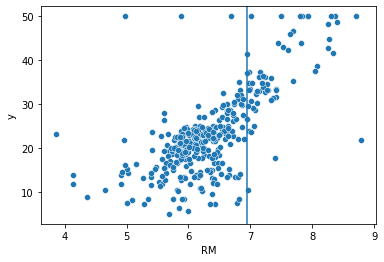

Left prediction: 20.08, right prediction: 36.82


In [13]:
node = tree.tree_
sns.scatterplot(x=X_train[:, node.column], y=y_train)
plt.xlabel(cols[node.column])
plt.ylabel('y')
plt.axvline(node.threshold)
plt.show()

print('Left prediction: {0:.2f}, right prediction: {1:.2f}'.format(node.left.prediction, node.right.prediction))

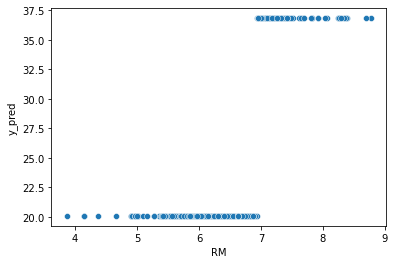

In [15]:
y_pred = tree.predict(X_train)
sns.scatterplot(x=X_train[:, node.column], y=y_pred)
plt.xlabel(cols[node.column])
plt.ylabel('y_pred')
plt.show()

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters (`max_depth` and `min_samples_split`) on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `RMSE` on test dataset and hyperparameters of the best estimator. 

In [16]:
from sklearn.model_selection import GridSearchCV

min_samples_splits = [1, 5, 10, 15, 20, 50]
max_depths = [2, 4, 6, 8, 10, 20, 25]

gs = GridSearchCV(MyDecisionTreeRegressor(), 
                  param_grid={'min_samples_split' : min_samples_splits, 'max_depth' : max_depths},
                  cv=5, 
                  scoring='neg_mean_squared_error')

gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MyDecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 20, 25],
                         'min_samples_split': [1, 5, 10, 15, 20, 50]},
             scoring='neg_mean_squared_error')

In [17]:
from sklearn.metrics import mean_squared_error

print(gs.best_params_)
best_estimator = gs.best_estimator_
y_pred = best_estimator.predict(X_test)

print('R2 score: ', r2_score(y_test, y_pred))
print('RMSE score: ', np.sqrt(mean_squared_error(y_test, y_pred)))

{'max_depth': 8, 'min_samples_split': 1}
R2 score:  0.848729766131725
RMSE score:  3.357322354615411


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized. 

In [18]:
def get_bias_variance(estimator, x, y, n_iter):
    """ 
    Calculate bias and variance of the `estimator`. Using a given dataset and bootstrap with `n_iter` samples. 

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in 
    Returns
    -------
    bias2 : float, 
        Estiamted squared bias
    variance : float, 
        Estiamted variance
    """
    
    bias2 = 0
    variance = 0
    
    matrix = np.empty((len(x), n_iter))
    matrix[:, :] = np.NaN
    
    # create n_iter samples from x
    dataset_len = len(x)
    for i in range(n_iter):
        indexes = range(dataset_len)
        sample_idx = np.random.choice(indexes, dataset_len, replace=True) # picking dataset_len indexes with repetitions
        oob_idx = [index for index in indexes if index not in sample_idx] # what did not picked in sample
        
        sample = x[sample_idx]
        oob = x[oob_idx]
        
        y_sample = y[sample_idx]
        y_oob = y[oob_idx]
        
        # fit on X_i aka sample
        estimator.fit(sample, y_sample)
        
        # make predictions on Z_i aka oob
        y_pred = estimator.predict(oob)
        
        # writing y_pred in i column of matrix, where nan means that element was in sample
        column = np.empty(dataset_len)
        
        # i did not manage to turn it into vector operation
        # but algorithm works pretty fast on our data
        for j in range(dataset_len):
            if j in oob_idx:
                column[j] = estimator.predict(x[j].reshape(1, -1))
            else:
                column[j] = np.NaN
        
        matrix[:, i] = column
    
    # i did not manage to turn it into vector operation too
    for i in range(dataset_len):
        y_true = y[i]
        b = np.nanmean(np.square(matrix[i] - y_true))
        v = np.nanmean(np.square(matrix[i] - np.nanmean(matrix[i])))
        bias2 += b if not np.isnan(b) else 0
        variance += v if not np.isnan(v) else 0
    
    return bias2 / dataset_len, variance / dataset_len

In [19]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, X_train, y_train, 10)

<ipython-input-18-dd5b502e941c>:59: RuntimeWarning: Mean of empty slice
  b = np.nanmean(np.square(matrix[i] - y_true))
<ipython-input-18-dd5b502e941c>:60: RuntimeWarning: Mean of empty slice
  v = np.nanmean(np.square(matrix[i] - np.nanmean(matrix[i])))


(28.952889689984524, 6.742302720400835)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees of different depths. Plot how bias and variance change as depth increases. 

Comment on what you observe, how does your result correspond to what we have discussed in class?

<AxesSubplot:>

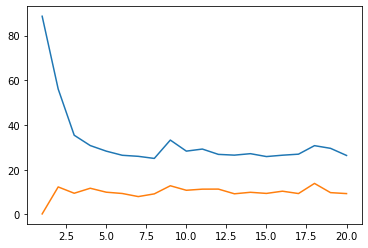

In [23]:
import warnings

biases = []
variances = []

for depth in range(1, 21):
    tree = MyDecisionTreeRegressor(max_depth=depth)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        b, v = get_bias_variance(tree, X_train, y_train, 20)
    biases.append(b)
    variances.append(v)
    
sns.lineplot(x=range(1, 21), y=biases)
sns.lineplot(x=range(1, 21), y=variances)

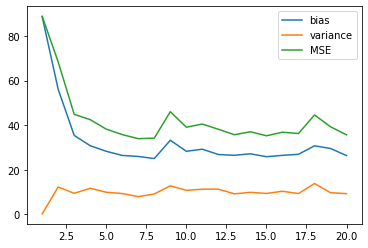

In [34]:
sns.lineplot(x=range(1, 21), y=biases, label='bias')
sns.lineplot(x=range(1, 21), y=variances, label='variance')
error = np.array(biases) + np.array(variances)
sns.lineplot(x=range(1, 21), y=error, label='MSE')
plt.show()

With increase of max_depth of decision tree bias is dropping and variance is growing, MSE = bias + variance is decreasing. 

As we saw in grid search the best max_depth in terms of MSE is 8. It can be seen from the graph above as well. Further increase of max_depth does not improve the model much, I think the reason is small dataset. 

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [35]:
from sklearn.ensemble import BaggingRegressor

bagging_regressor = BaggingRegressor(base_estimator=MyDecisionTreeRegressor(),
                                     n_estimators=15,
                                     random_state=42)

bagging_regressor.fit(X_train, y_train)

BaggingRegressor(base_estimator=MyDecisionTreeRegressor(), n_estimators=15,
                 random_state=42)

In [36]:
y_pred = bagging_regressor.predict(X_test)
print('RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

RMSE: 4.5807


In [38]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    b, v = get_bias_variance(bagging_regressor, X_train, y_train, 10)
    print('Bias: {0:.4f}, Variance: {1:.4f}'.format(b, v))

Bias: 25.5027, Variance: 2.2619


In [40]:
# best in terms of mse our model withot bagging is with max_depth=8 
print('Best model without bagging:\nBias: {0:.4f}, Variance: {1:.4f}'.format(biases[7], variances[7]))

Best model without bagging:
Bias: 25.0391, Variance: 9.1776


In theory main puprose of bagging is reducing variance. Algorithm averages a set of independent weak models. Bootstarp samples are approximately independent and identically distributed, so averaging them would not affect expected answer, but would reduce variance. In theory. 

In my experiment variance decreased significantly from 9.17 to 2.26. Bias remained almost the same.

# Part 2. More Ensembles

In this part we will be working with [Thyroid Disease Data Set](https://archive.ics.uci.edu/ml/datasets/thyroid+disease) to solve a classification task. 

In [61]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('thyroid_disease.csv')

le = LabelEncoder()
y = le.fit_transform(df['Class'])
X = df.drop('Class', axis=1)
X.head(5)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source
0,41.0,F,f,f,f,f,f,f,f,f,...,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC
1,23.0,F,f,f,f,f,f,f,f,f,...,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other
2,46.0,M,f,f,f,f,f,f,f,f,...,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other
3,70.0,F,t,f,f,f,f,f,f,f,...,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other
4,70.0,F,f,f,f,f,f,f,f,f,...,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transorm1, column_names1),
    ('name2', transorm2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset. 

In [62]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

X.isnull().sum()

age                             1
sex                           150
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
sick                            0
pregnant                        0
thyroid_surgery                 0
I131_treatment                  0
query_hypothyroid               0
query_hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH_measured                    0
TSH                           369
T3_measured                     0
T3                            769
TT4_measured                    0
TT4                           231
T4U_measured                    0
T4U                           387
FTI_measured                    0
FTI                           385
TBG_measured                    0
TBG                          3772
referral_source                 0
dtype: int64

In [47]:
X.shape

(3772, 29)

TBG column is all NaN, dropping it. T3 has roughly 20% missing values, let's drop it too. Other columns have less than 10% of missing, so (in theory) filling with average value does not affect result much

In [63]:
X = X.drop(['TBG', 'T3'], axis=1)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [65]:
# define column_transformer 

categorical_columns = [c for c in X.columns if X[c].dtype.name == 'object']
numerical_columns   = [c for c in X.columns if X[c].dtype.name != 'object']

column_transformer = ColumnTransformer([('numeric', SimpleImputer(), numerical_columns),
                                 ('categorical', make_pipeline(
                                     SimpleImputer(strategy='most_frequent'), 
                                     OneHotEncoder()), categorical_columns)], 
                                       remainder='passthrough')

# Transform the data
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [66]:
# let's find out whether out dataset balanced or not
print('% of 0 class', len(y[y == 0]) / len(y))

% of 0 class 0.9387592788971368


Well, it is imbalanced

Let's suppose we do not want to miss a disease case and we do not want to set diagnosis to a healthy patient, so  False Negative and False Positive are equally important. Also we want to look at probabilities of each class.

According to this [article](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/) the best metric for this case is ROC AUC

Also F1 can be used if we want only class prediction, not probabilities

In [71]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score

cv = StratifiedShuffleSplit(n_splits=5, random_state=42)
estimators = [GradientBoostingClassifier(), 
              RandomForestClassifier(), 
              DecisionTreeClassifier(), 
              SVC(), 
              LogisticRegression(C=0.1)]

scores = {}
test_scores = {}

for estimator in estimators:
    scores[estimator.__class__.__name__] = cross_val_score(estimator, X_train, y_train, cv=cv, scoring='roc_auc')
    test_scores[estimator.__class__.__name__] = estimator.fit(X_train, y_train).predict(X_test)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

**Accuracy score**

Not very representive as classes are not balanced

<AxesSubplot:>

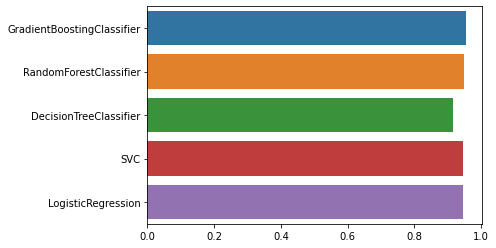

In [105]:
from sklearn.metrics import accuracy_score, plot_roc_curve

test_accuracy = [accuracy_score(test_scores[name], y_test) for name in test_scores]

sns.barplot(x=test_accuracy, y=pd.Index(list(test_scores.keys())))

**Mean Cross-Validation Score**

Gradient Boosting has the best result, decision tree the worst

<AxesSubplot:>

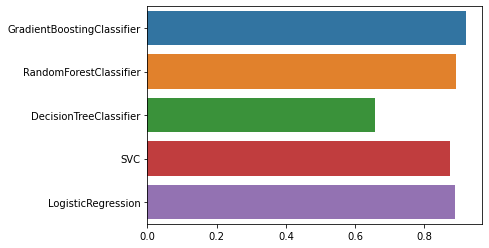

In [114]:
mean_score = [np.mean(list(scores[key])) for key in scores]

sns.barplot(x=mean_score, y=pd.Index(list(scores.keys())))

In [116]:
mean_score

[0.9213384139080734,
 0.8915694212907834,
 0.6566325315551322,
 0.8746844486782568,
 0.8874970231007383]

In [117]:
scores['DecisionTreeClassifier']

array([0.69171231, 0.62681591, 0.72112408, 0.61871874, 0.62479162])

**ROC Curve with ROC-AUC score**

In [155]:
for estimator in estimators:
    y_pred = estimator.predict(X_test)
    print(roc_auc_score(y_test, y_pred))

0.6597327455572393
0.6018888429688816
0.6309944742924493
0.5
0.5304526182057523


Gradient Boosting has the best ROC-AUC score on train and test data, slightly worse is Logistic Regression, Random Forest and SVM. Decision tree has the worst result, I suppose it is too simple for this data

### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. Choose one of the tree popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 



In [118]:
!pip install xgboost

     |████████████████████████████████| 1.2 MB 2.0 MB/s eta 0:00:01


In [157]:
from xgboost import XGBClassifier

params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': np.logspace(-4, -2, 5),
    'max_depth': [5, 10, 15, 20, 30, 100]
}

gs = GridSearchCV(XGBClassifier(booster='gbtree', 
                                use_label_encoder=False, 
                                eval_metric='logloss'), 
                  param_grid=params, scoring='roc_auc', cv=5)

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsam

In [158]:
print('Best ROC-AUC score:', gs.best_score_)
print('best params: ', gs.best_params_)

Best ROC-AUC score: 0.8612110026196713
best params:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}


In [159]:
est = gs.best_estimator_

y_pred = est.predict(X_test)
print('ROC-AUC on test data: ', roc_auc_score(y_test, y_pred))

ROC-AUC on test data:  0.635609435030843


ROC-AUC score is not better than gradient boosting from previous task

Let's try to increase number of estimators with lr=0.01, max_depth is small, like [3, 5, 7, 10]

In [160]:
params = {
    'n_estimators': [200, 300, 400, 600, 1000],
    'max_depth': [3, 5, 7, 10]
}

gs = GridSearchCV(XGBClassifier(booster='gbtree', 
                                use_label_encoder=False, 
                                eval_metric='logloss', 
                                learning_rate=0.01), 
                  param_grid=params, scoring='roc_auc', cv=5)

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.01, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsam

In [161]:
print('Best ROC-AUC score:', gs.best_score_)
print('best params: ', gs.best_params_)

Best ROC-AUC score: 0.8898130507263634
best params:  {'max_depth': 3, 'n_estimators': 1000}


In [162]:
est = gs.best_estimator_

y_pred = est.predict(X_test)
print('ROC-AUC on test data: ', roc_auc_score(y_test, y_pred))

ROC-AUC on test data:  0.6274127137193676


Not better

Seems like the best option is many-many simple trees, let's try even more

In [132]:
print('Best ROC-AUC score:', gs.best_score_)
print('best params: ', gs.best_params_)

Best ROC-AUC score: 0.8910693022148131
best params:  {'n_estimators': 2000}


So, the best parameters I got with this model are learning_rate=0.01, max_depth=3, n_estimators=200

ROC-AUC score on test data is 0.63, better than gradient boosting from previous task

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [143]:
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier

bagging_trees = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=20)
bagging_gb = BaggingClassifier(base_estimator=GradientBoostingClassifier(), n_estimators=200)

clf1 = LogisticRegression(random_state=42)
clf2 = RandomForestClassifier(n_estimators=50, random_state=42)
clf3 = GradientBoostingClassifier()
voting = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gb', clf3)], voting='hard')

clf4 = RandomForestClassifier(n_estimators=50, random_state=42)
clf5 = SVC()
stacking_log = StackingClassifier(estimators=[('rfc', clf4), ('svm', clf5)], final_estimator=LogisticRegression())

clf6 = RandomForestClassifier(n_estimators=50, random_state=42)
clf7 = SVC()
stacking_gb = StackingClassifier(estimators=[('rfc', clf6), ('svm', clf7)], final_estimator=GradientBoostingClassifier())

In [144]:
ensembles = [bagging_trees, bagging_gb, voting, stacking_log, stacking_gb]

for ensemble in ensembles:
    ensemble.fit(X_train, y_train)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [145]:
from sklearn.metrics import roc_auc_score

for ensemble in ensembles:
    y_pred = ensemble.predict(X_train)
    train_score = roc_auc_score(y_train, y_pred)
    y_pred = ensemble.predict(X_test)
    test_score = roc_auc_score(y_test, y_pred)
    print('{0} - Train ROC-AUC score: {1:.4f}\tTest ROC-AUC score: {2:.4f}'
          .format(ensemble.__class__.__name__, train_score, test_score))

BaggingClassifier - Train ROC-AUC score: 0.9765	Test ROC-AUC score: 0.6260
BaggingClassifier - Train ROC-AUC score: 0.6960	Test ROC-AUC score: 0.6279
VotingClassifier - Train ROC-AUC score: 0.7292	Test ROC-AUC score: 0.5796
StackingClassifier - Train ROC-AUC score: 0.9706	Test ROC-AUC score: 0.5314
StackingClassifier - Train ROC-AUC score: 0.6184	Test ROC-AUC score: 0.6150


**Summary**

1. Bagging with decision trees has overfitted, may be with GridSearch to find number of estimators would be useful
2. Bagging with GB seems not overfitted, but the result is way worse than previous models
3. Voting has overfitted, but perfomance on train dataset worse than 1 and 4
4. Stacking with final model as Logistic Regression has overfitted even worse than 1. 
5. Stacking with final model as Gradient Boosting has not overfitted, but the result is a bit better than simple guessing.

***Let's try to improve the first model***

In [150]:
def gridsearch(estimator, params):
    gs = GridSearchCV(estimator, param_grid=params, cv=5, scoring='roc_auc')
    gs.fit(X_train, y_train)
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_train)
    train_score = roc_auc_score(y_train, y_pred)
    y_pred = best_model.predict(X_test)
    test_score = roc_auc_score(y_test, y_pred)
    res_str = '{0} - Train ROC-AUC score: {1:.4f}\tTest ROC-AUC score: {2:.4f}'.format(best_model.__class__.__name__, train_score, test_score)
    
    return gs.best_params_, res_str

In [151]:
bagging_trees = BaggingClassifier(base_estimator=DecisionTreeClassifier())
bagging_trees_params = {'n_estimators' : [10, 20, 50, 100]}

best_params_trees, res_str_trees = gridsearch(bagging_trees, bagging_trees_params)

print(best_params_trees, '\n', res_str_trees)

{'n_estimators': 100} 
 BaggingClassifier - Train ROC-AUC score: 1.0000	Test ROC-AUC score: 0.6511


It became more overfitted in terms of roc-auc score, but test score is better

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train. 

The best ROC-AUC score I managed to get is 0.65 for Gradient Boosting Classifier and 0.65 for Bagging Classifier with decision trees as base models

In [164]:
from sklearn.metrics import f1_score, precision_score, recall_score

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

print('Different metrics for Gradient Boosting from scikit-learn')
print('ROC-AUC:   ', roc_auc_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall:    ', recall_score(y_test, y_pred))
print('Accuracy:  ', accuracy_score(y_test, y_pred))
print('F1:        ', f1_score(y_test, y_pred))

Different metrics for Gradient Boosting from scikit-learn
ROC-AUC:    0.6597327455572393
Precision:  0.6896551724137931
Recall:     0.32786885245901637
Accuracy:   0.9558303886925795
F1:         0.4444444444444445


In [167]:
bagging_trees = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100)
bagging_trees.fit(X_train, y_train)
y_pred = bagging_trees.predict(X_test)

print('Different metrics for Bagging with decision trees')
print('ROC-AUC:   ', roc_auc_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall:    ', recall_score(y_test, y_pred))
print('Accuracy:  ', accuracy_score(y_test, y_pred))
print('F1:        ', f1_score(y_test, y_pred))

Different metrics for Bagging with decision trees
ROC-AUC:    0.6487349037975847
Precision:  0.5588235294117647
Recall:     0.3114754098360656
Accuracy:   0.9496466431095406
F1:         0.4
